# Lesson 5

Our goal is to match computer simulations to real experiments. Computer simulations are also cheaper to do and can be used to tell us if the real experiment can even answer the question we want to ask. The idea is to build the experiment synthetically first and then try to match against the synthetic data and see if under ideal circumstances if you can identify the parameters of interest. If you can't do it synthetically you can't do it in real life either which has many sources of error. Many times I have seen experiments run which turned out to have no chance of providing the required information because the experiment was run before figuring out what experiment should be run.

## Purpose

The goal of this section is to learn how to setup, run and analyze a parameter estimation run. 

The example used is from Lesson 1 which is a simple Dextran pulse through a column. This lesson will cover the the common variable transforms, scores and search algorithms.

## Load CADETSettings

This imports all the standard libraries, finds CADET and find and creates all the lesson folders.

In [1]:
%run CADETSettings.ipynb

CADET was found. Continue to the next step.


## Load simple example from Lesson 1
This code is pretty much the same as what we have looked at before. We open the file from Lesson 1 and then resave it to the Lesson 4 folder. We also run the simulation and save the output of the chromatogram as a CSV file to use in the matching process.

CompletedProcess(args=['C:/Users/kosh_000/CADET/cadet/bin/cadet-cli.exe', 'C:/Users/kosh_000/CADET/lessons/lesson_5/example_0/example.h5'], returncode=0, stdout=b'', stderr=b'')
Simulation completed successfully


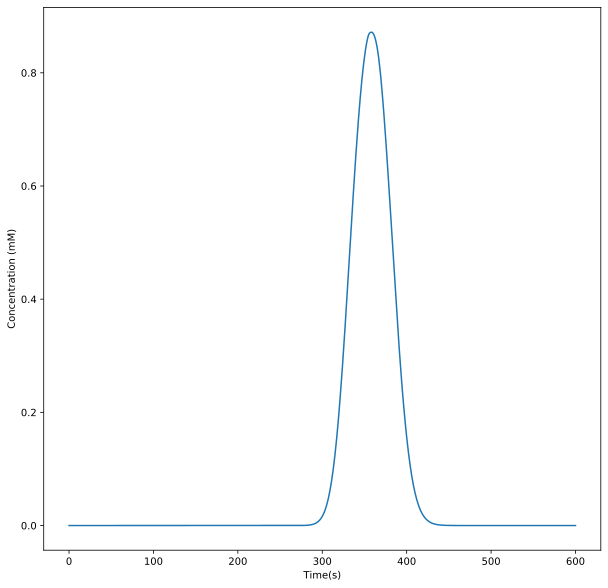

In [2]:
example_dir_0 = lesson_5 / "example_0"
example_dir_0.mkdir(exist_ok = True)

example0 = Cadet()

#give a filename for where the simulation should be saved
example0.filename = (lesson_1 / 'example_0' / 'example.h5').as_posix()

example0.load()

example0.filename = (example_dir_0 / 'example.h5').as_posix()

#save the simulation
example0.save()

#run the simulation
data = example0.run()

print(data)

if data.returncode == 0:
    print("Simulation completed successfully")
    
    #load the data from the simulation so we can view the results
    example0.load()
    
    #plot the simulation
    plt.figure(figsize=[10,10])
    plt.plot(example0.root.output.solution.solution_times,
        example0.root.output.solution.unit_002.solution_outlet_comp_000)
    plt.xlabel('Time(s)')
    plt.ylabel('Concentration (mM)')
    plt.show()
    
    #write the chromatogram data out to a csv file
    data = pandas.DataFrame([example0.root.output.solution.solution_times,
                        example0.root.output.solution.unit_002.solution_outlet_comp_000]).transpose()
    data.to_csv((example_dir_0 / 'example.csv').as_posix(), index=False, header=False)
    
else:
    print("Simulation failed")

## Try to optimize manually

First lets try just optimizing the function manually and looking at the result with sum squared error as a score.

In [3]:
def goal(axial_dispersion=-5, column_porosity=0.4):
    axial_dispersion = 10**axial_dispersion
    #create and run simulation
    example0_temp = Cadet(example0.root)
    example0_temp.filename = (example_dir_0 / 'example_temp.h5').as_posix()
    example0_temp.root.input.model.unit_001.col_dispersion = axial_dispersion
    example0_temp.root.input.model.unit_001.col_porosity = column_porosity
    example0_temp.save()
    example0_temp.run()
    example0_temp.load()
    
    #print error
    sse = numpy.sum( (example0.root.output.solution.unit_002.solution_outlet_comp_000 - example0_temp.root.output.solution.unit_002.solution_outlet_comp_000)**2 )   
    
    print('SSE %.3g' % sse)
    
    #create plots
    plt.figure(figsize=[15,10])
    plt.plot(example0.root.output.solution.solution_times,
        example0.root.output.solution.unit_002.solution_outlet_comp_000, label='Goal')
    plt.plot(example0.root.output.solution.solution_times,
        example0_temp.root.output.solution.unit_002.solution_outlet_comp_000, label='Test')
    plt.legend()
    plt.xlabel('Time(s)')
    plt.ylabel('Concentration (mM)')
    
style = {'description_width': 'initial'}
interact(goal, axial_dispersion=widgets.FloatSlider(min=-10, max=-5, step=0.1, layout={'width': '800px'}, style=style, description="Axial Dispersion"),
        column_porosity=widgets.FloatSlider(min=0.1, max=0.9, step=0.01, layout={'width': '800px'}, style=style, description='Column Porosity'))

interactive(children=(FloatSlider(value=-5.0, description='Axial Dispersion', layout=Layout(width='800px'), ma…

<function __main__.goal(axial_dispersion=-5, column_porosity=0.4)>

## Create CADETMatch configuration

### Search Method
There are 4 main search methods and only 3 of them are directly used.
1. NSGA3
  This is the default evolutionary algorithm and the best choice to use when you don't know anything about your search space.
2. Multistart
  This is a multistart gradient descent algorithm. If your problem can be solved with gradient descent then this can be a very good choice. It creates an initial population the same way that NSGA3 does so that you don't have to worry about starting point. 
3. GraphSpace
  This is not for optimization and instead it is just for sampling the space. If you have a new problem and you have no idea what the range of any of the parameters are you can use this with a very large population and it will just evaluate the entire starting population and then terminate. This allows you to figure out what are plausiable ranges for your variables before using one of the search algorithms. When dealing with many variables it is still possible to miss regions of viable solutions inside large non-viable regions but in practice this has rarely been a problem.
4. MCMC
  This performans the error modeling and sampling. It is not an optimization algorithm and while it will probably find the optimum value while it runs it is very slow to do so and won't stop even if it finds the optimal value. This should also not be used directly. Normally NSGA3 is used and an option is set to continue with MCMC after NSGA3 has completed. This allows MCMC to be seeded with the best values from NSGA3 which dramatically improves convergence. If you have many variables and you run this directly it may never converge since it may never find high probability regions, much less sample from them effectively.  

In [4]:
def create_match(ax_dis, col_por):
    match = Dict()
    match.CADETPath = cadet_path.as_posix()
    match.baseDir = example_dir_0.as_posix()
    match.resultsDir = 'fit_grad'
    match.searchMethod = 'Gradient'
    match.seeds = [(ax_dis, col_por), ]
    
    parameter1 = Dict()
    parameter1.transform = 'null'
    parameter1.component = -1
    parameter1.bound = -1
    parameter1.location = "/input/model/unit_001/COL_DISPERSION"
    parameter1.min = 1e-10
    parameter1.max = 1e-5

    parameter2 = Dict()
    parameter2.transform = 'null'
    parameter2.component = -1
    parameter2.bound = -1
    parameter2.location = "/input/model/unit_001/COL_POROSITY"
    parameter2.min = 0.1
    parameter2.max = 0.9

    match.parameters = [parameter1, parameter2]

    experiment1 = Dict()
    experiment1.csv = "example.csv"
    experiment1.isotherm = "/output/solution/unit_002/SOLUTION_OUTLET_COMP_000"
    experiment1.HDF5 = "example.h5"
    experiment1.name = "main"
 
    feature1 = Dict()
    feature1.name = "Pulse"
    feature1.type = 'SSE'

    experiment1.features = [feature1,]

    match.experiments = [experiment1,]

    return match   

In [5]:
style = {'description_width': 'initial'}
axial_dispersion=widgets.FloatSlider(min=-10, max=-5, step=0.1, layout={'width': '800px'}, style=style, description="Axial Dispersion")
column_porosity=widgets.FloatSlider(min=0.1, max=0.9, step=0.01, layout={'width': '800px'}, style=style, description='Column Porosity')
button = widgets.Button(description='Start Gradient Search')
run_sim = widgets.Button(description='Run simulation')

output = widgets.Output()
output_graph = widgets.Output()
output_search = widgets.Output()

import matplotlib

def click_search(b):
    with output:
        clear_output(wait=True)
        print("Axial Dispersion", 10**axial_dispersion.value)
        print("Column Porosity", column_porosity.value)

    with output_search:
        clear_output(wait=True)
        
        match = create_match(10**axial_dispersion.value, column_porosity.value)

        match_file = example_dir_0 / 'example.json'

        with (match_file).open('w') as json_file:
            json.dump(match.to_dict(), json_file, indent='\t')
            
        match = simple_run_match(match, match_file, delete=True)

    best ,score, best_score = match.get_best()

    for data in best_score.values():
        axial_dispersion_best = numpy.log10(data[0])
        column_porosity_best = data[1]

        goal(axial_dispersion_best, column_porosity_best)
        break
        

def goal(axial_dispersion=-5, column_porosity=0.4):
    axial_dispersion = 10**axial_dispersion

    with output:
        clear_output(wait=True)
        print("Axial Dispersion %.3g" % axial_dispersion)
        print("Column Porosity %.3g" % column_porosity)

        #create and run simulation
        example0_temp = Cadet(example0.root)
        example0_temp.filename = (example_dir_0 / 'example_temp.h5').as_posix()
        example0_temp.root.input.model.unit_001.col_dispersion = axial_dispersion
        example0_temp.root.input.model.unit_001.col_porosity = column_porosity
        example0_temp.save()
        example0_temp.run()
        example0_temp.load()

        #print error
        sse = numpy.sum( (example0.root.output.solution.unit_002.solution_outlet_comp_000 - example0_temp.root.output.solution.unit_002.solution_outlet_comp_000)**2 )   

        print('SSE %.3g' % sse)

    with output_graph:
        clear_output(wait=True)
        #create plots
        plt.figure(figsize=[15,6])
        plt.plot(example0.root.output.solution.solution_times,
            example0.root.output.solution.unit_002.solution_outlet_comp_000, label='Goal')
        plt.plot(example0_temp.root.output.solution.solution_times,
            example0_temp.root.output.solution.unit_002.solution_outlet_comp_000, label='Test')
        plt.legend()
        plt.xlabel('Time(s)')
        plt.ylabel('Concentration (mM)')
        plt.show()

def run_goal(b):
    goal(axial_dispersion.value, column_porosity.value)
        
button.on_click(click_search)
run_sim.on_click(run_goal)

call_goal = interactive(goal, axial_dispersion=axial_dispersion, column_porosity=column_porosity)

vbox = widgets.VBox([call_goal, button, output, output_graph, output_search])

display(vbox)